In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import time
import sklearn
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for model in mpl, np, pd, sklearn, keras:
    print(model.__name__, model.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.0
pandas 1.0.5
sklearn 0.23.1
tensorflow_core.keras 2.2.4-tf


In [2]:
# 回归问题
# 加利福利亚
from sklearn.datasets import fetch_california_housing
#加载数据
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
import pprint
#展示数据 查看规律
pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
from sklearn.model_selection import train_test_split

#数据切割 训练集 验证集 测试
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7, test_size=0.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

#数据归一化
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled =  scaler.transform(x_test)

In [6]:
# 函数式API    
#多输入 
input_wide = keras.layers.Input(5)
input_deep = keras.layers.Input(6)
hidden1 = keras.layers.Dense(30,activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide,hidden2])
#多输出
output = keras.layers.Dense(1)(concat)
output2 = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs=[input_wide,input_deep],
                           outputs=[output,output2])


model.summary()
model.compile(loss='mean_squared_error', optimizer='Adagrad', metrics=['accuracy'])

logdir = os.path.join('wide-deep-multi-output-callbacks')
if not os.path.exists(logdir):
    os.mkdir(logdir)

callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2),
             keras.callbacks.TensorBoard(logdir)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [7]:
x_train_scaled_wide = x_train_scaled[:,:5] #前5个特征
x_train_scaled_deep = x_train_scaled[:,2:] #后6个特征
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]

history = model.fit([x_train_scaled_wide,x_train_scaled_deep],[y_train,y_train], 
                    validation_data = ([x_valid_scaled_wide,x_valid_scaled_deep],[y_valid,y_valid]), 
                    epochs=20, 
                    callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 270us/sample - loss: 8.6496 - dense_2_loss: 4.4546 - dense_3_loss: 4.1953 - dense_2_accuracy: 0.0000e+00 - dense_3_accuracy: 7.7519e-04 - val_loss: 6.6138 - val_dense_2_loss: 3.3157 - val_dense_3_loss: 3.2983 - val_dense_2_accuracy: 7.7519e-04 - val_dense_3_accuracy: 0.0016
Epoch 2/20
11610/11610 [==============================] - 1s 95us/sample - loss: 5.2532 - dense_2_loss: 2.6050 - dense_3_loss: 2.6476 - dense_2_accuracy: 0.0012 - dense_3_accuracy: 0.0030 - val_loss: 4.6770 - val_dense_2_loss: 2.2475 - val_dense_3_loss: 2.4296 - val_dense_2_accuracy: 0.0016 - val_dense_3_accuracy: 0.0018
Epoch 3/20
11610/11610 [==============================] - 1s 90us/sample - loss: 3.8917 - dense_2_loss: 1.8220 - dense_3_loss: 2.0695 - dense_2_accuracy: 0.0023 - dense_3_accuracy: 0.0030 - val_loss: 3.7555 - val_dense_2_loss: 1.7173 - val_dense_3_loss: 2.0382 - val_dense_2_accuracy: 0.0016 

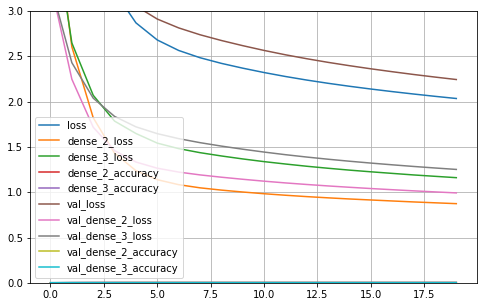

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()

plot_learning_curves(history)

In [11]:
model.evaluate([x_test_scaled_wide,x_test_scaled_deep], [y_test,y_test])

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.408519323851711, 0.9170805, 1.4905374, 0.0032945736, 0.0032945736]